In [2]:
# !pip install --upgrade missingpy pyspark FLAML "flaml[spark]" optuna "scikit-learn==1.1.2" xgboost catboost imblearn
# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.
# This behaviour is the source of the following dependency conflicts.
# bigframes 1.6.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.2 which is incompatible.
!pip install catboost FLAML "flaml[spark]" geopy gspread imbalanced-learn ipykernel matplotlib missingpy numpy \
    openpyxl openai openml optuna optuna-integration \
        pandas pip plotly_express polars PyCap pygsheets python-dotenv pyspark \
            seaborn scipy setuptools "scikit-learn==1.1.2" shap statsmodels tabulate tabula-py wheel xlsx2csv xgboost
from google.colab import drive
drive.mount('/content/drive')
# https://www.ncbi.nlm.nih.gov/books/NBK482489/

^C
ERROR: Operation cancelled by user


ModuleNotFoundError: No module named 'google.colab'

## Loading Necessary Packages

In [1]:
# import necessary packages
import sys
import os
if '/content/drive/MyDrive/MPH_2024/mphd_assignment_4' not in sys.path:
    sys.path.append('/content/drive/MyDrive/MPH_2024/mphd_assignment_4')
if os.path.dirname(os.getcwd()) not in sys.path:
    sys.path.append(os.path.dirname(os.getcwd()))

# !nvidia-smi
# %load_ext cudf.pandas
import pandas as pd
import numpy as np
import polars as pl
import wh0102 as mphd

## Load the data and check for missing values

In [2]:
# Prepare the data dictionary
data_dictionary = {
    "Ethnic":{0:"Malay", 1:"Chinese", 2:"Indian"},
    "bmi":{0:"Normal BMI", 1:"Overweight"},
    "Disease":{0:"No liver disease", 1:"Have Liver Disease"},
    "Gender":{0:"Female", 1:"Male"}
}

# Rename for easier references
column_to_be_rename = {"Sgot":"ALT",
                       "Sgpt":"AST",
                       "Alkphos":"ALP"}

# To be use as guidance
normal_value = {"TP":[64, 83],
                "ALB":[35, 52],
                "TB":[0, 22],
                "ALP":[40, 130],
                "ALT":[0, 42],
                "AST":[0, 41]}

# Prepare the variables
dependent_variable = "Disease"
independent_demographic = ("Age", "Gender", "Ethnic", "bmi",)
independent_investigations = ("AGR", "ALB", "TP", "TB", "DB", "ALP", "ALT", "AST",)
independent_continous = (independent_demographic[0],) + independent_investigations
independent_categorical = independent_demographic[1:]
independent_variables = independent_demographic + independent_investigations

# Load the data
df = pd.read_csv(r"/content/drive/MyDrive/MPH_2024/mphd_assignment_4/assignment4.csv")

# Rename the column name
df = df.rename(columns = column_to_be_rename)

# To reassign the categorical value
for column in [key for key in data_dictionary.keys() if key != "Gender"]:
    df.loc[:,column] = df.loc[:,column] - 1

# Print the information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Patient_ID  553 non-null    int64  
 1   Age         553 non-null    int64  
 2   TB          553 non-null    float64
 3   DB          553 non-null    float64
 4   ALP         553 non-null    int64  
 5   ALT         553 non-null    int64  
 6   AST         553 non-null    int64  
 7   TP          553 non-null    float64
 8   ALB         553 non-null    float64
 9   AGR         553 non-null    object 
 10  Disease     553 non-null    int64  
 11  Ethnic      553 non-null    int64  
 12  Gender      553 non-null    object 
 13  bmi         553 non-null    int64  
dtypes: float64(4), int64(8), object(2)
memory usage: 60.6+ KB


In [3]:
# Convert the gender
df = mphd.categorical_data.label_encode(df = df, columns = "Gender", convert_numeric=True)
# "Gender":{0:"Female", 1:"Male"}

# Check for duplication
duplicated_df, to_drop_duplicated_df = mphd.pre_processing.check_duplication(df)

# Check for missing value
missing_df = mphd.missing_values.analyse_missing_row(df)
missing_df

No duplication found in the dataset.
Missing data detected for columns AGR.
Summary of the missing values from the dataframe =
+------------------------------+-------+--------------------+
|                              | count | missing_percentage |
+------------------------------+-------+--------------------+
|             AGR              |  4.0  |        0.72        |
| All_rows_with_missing_values |  4.0  |        0.72        |
+------------------------------+-------+--------------------+


,Patient_ID,Age,TB,DB,ALP,ALT,AST,TP,ALB,AGR,Disease,Ethnic,Gender,bmi
140,141,45,0.9,0.3,189,33,23,6.6,3.9,NaN,0,0,0,0
160,161,51,0.8,0.2,230,46,24,6.5,3.1,NaN,0,0,1,0
450,451,35,0.6,0.2,180,15,12,5.2,2.7,NaN,1,2,0,1
468,469,27,1.3,0.6,106,54,25,8.5,4.8,NaN,1,0,1,0


## To fix AGR == ' ' issue

In [4]:
# Calculate the Globulin for every patient ID with globulin = tp - alb based on resource below:
# https://www.ncbi.nlm.nih.gov/books/NBK204/#:~:text=The%20total%20globulin%20fraction%20is,of%20further%20fractionating%20serum%20proteins

# To check the truthness of this on the data
# Create a deep copy of the df with AGR not null first
temp_df = df.query("AGR.notnull()").copy(deep = True)

# Calculatet the globulin and agr_ratio
def calculate_agr(df:pd.DataFrame, column_name:str):
    df.loc[:,column_name] = df.loc[:,"ALB"] / (df.loc[:,"TP"] - df.loc[:,"ALB"])
    return df

# Calculate the approximate agr
temp_df = calculate_agr(df = temp_df, column_name = "agr_new")
# Check for float similarity
temp_df.loc[:,"agr_similarity"] = temp_df.loc[:,("AGR", "agr_new",)].apply(lambda x: np.isclose(float(x[0]), x[1], rtol = 0.1), axis = 1)

# Pivot the information
pt = temp_df.pivot_table(index = "agr_similarity", values = "Patient_ID", aggfunc = len, margins = True)\
            .rename(columns={"Patient_ID":"count"})
# Calculate percentage
pt.loc[:,"percentage"] = round(pt.loc[:,"count"] / pt.loc["All", "count"] * 100, 2)
# Print the pivot table information
print(pt.to_markdown(tablefmt = "pretty"))

# Check on the not similarity result
print("Viewing on data with agr_similarity == False")
print(temp_df.query("agr_similarity == False").to_markdown(tablefmt = "pretty"))

# Trial to impute with calculation
print("If compute directly based on formula for the missing AGR data:")
missing_df = calculate_agr(df = missing_df, column_name="AGR")
missing_df

+----------------+-------+------------+
| agr_similarity | count | percentage |
+----------------+-------+------------+
|     False      | 48.0  |    8.74    |
|      True      | 501.0 |   91.26    |
|      All       | 549.0 |   100.0    |
+----------------+-------+------------+
Viewing on data with agr_similarity == False
+-----+------------+-----+------+------+------+------+-----+-----+-----+------+---------+--------+--------+-----+---------------------+----------------+
|     | Patient_ID | Age |  TB  |  DB  | ALP  | ALT  | AST | TP  | ALB | AGR  | Disease | Ethnic | Gender | bmi |       agr_new       | agr_similarity |
+-----+------------+-----+------+------+------+------+-----+-----+-----+------+---------+--------+--------+-----+---------------------+----------------+
|  9  |     10     | 72  | 2.7  | 1.3  | 260  |  56  | 31  | 7.4 | 3.0 | 0.6  |    0    |   0    |   1    |  1  | 0.6818181818181818  |     False      |
| 32  |     33     | 45  | 0.7  | 0.2  | 170  |  14  | 21  | 5.

/var/folders/kx/mhdv49d913j0rf2b8xmgtmhw0000gn/T/ipykernel_20680/3682345084.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp_df.loc[:,"agr_similarity"] = temp_df.loc[:,("AGR", "agr_new",)].apply(lambda x: np.isclose(float(x[0]), x[1], rtol = 0.1), axis = 1)


,Patient_ID,Age,TB,DB,ALP,ALT,AST,TP,ALB,AGR,Disease,Ethnic,Gender,bmi
140,141,45,0.9,0.3,189,33,23,6.6,3.9,1.444444,0,0,0,0
160,161,51,0.8,0.2,230,46,24,6.5,3.1,0.911765,0,0,1,0
450,451,35,0.6,0.2,180,15,12,5.2,2.7,1.08,1,2,0,1
468,469,27,1.3,0.6,106,54,25,8.5,4.8,1.297297,1,0,1,0


In [5]:
# Impute with MICE
# https://medium.com/@brijesh_soni/topic-9-mice-or-multivariate-imputation-with-chain-equation-f8fd435ca91#:~:text=MICE%20stands%20for%20Multivariate%20Imputation,produce%20a%20final%20imputed%20dataset.

mice_df = mphd.missing_values.mice_imputation(df = df, columns = "AGR")
# Check on the imputated value
mice_df.loc[missing_df.index]

,Patient_ID,Age,TB,DB,ALP,ALT,AST,TP,ALB,AGR,Disease,Ethnic,Gender,bmi
140,141,45,0.9,0.3,189,33,23,6.6,3.9,1.299105,0,0,0,0
160,161,51,0.8,0.2,230,46,24,6.5,3.1,0.908333,0,0,1,0
450,451,35,0.6,0.2,180,15,12,5.2,2.7,1.006441,1,2,0,1
468,469,27,1.3,0.6,106,54,25,8.5,4.8,1.361591,1,0,1,0


In [ ]:
# Impute with MissingForest
# https://betterdatascience.com/python-missforest-algorithm/#google_vignette

mf_df = mphd.missing_values.miss_forest_imputation(df=df, columns = "AGR")
# Check on the imputated value
mf_df.loc[missing_df.index]

## Interpretation for AGR == ' ' issue:
For imputation, despite the logic of how AGR being calculated, there is a lot of noise in the data for AGR value, therefore we would use MICE for imputation as it is more near to formula result compare to missing forest imputation.

In [7]:
# %load_ext cudf.pandas

# Reverse Encode
data = mphd.categorical_data.reverse_encode(df = mice_df,
                                            json_dict={key:value for key, value in data_dictionary.items() if key != "disease"})

/Users/wh0102/Downloads/github/7046_mphd/wh0102/descriptive_analysis/categorical_data.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Malay' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.loc[temp_df.loc[:,key1] == key2, key1] = values2
/Users/wh0102/Downloads/github/7046_mphd/wh0102/descriptive_analysis/categorical_data.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Normal BMI' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.loc[temp_df.loc[:,key1] == key2, key1] = values2
/Users/wh0102/Downloads/github/7046_mphd/wh0102/descriptive_analysis/categorical_data.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'No liver disease' has d

## Descriptive Analaysis For Continous Data

+-----------------+----------+--------+---------+---------+---------+---------+------------+------------+------------+---------+
|                 |   Age    |  AGR   |   ALB   |   TP    |   TB    |   DB    |    ALP     |    ALT     |    AST     | Disease |
+-----------------+----------+--------+---------+---------+---------+---------+------------+------------+------------+---------+
|      count      |  553.0   | 553.0  |  553.0  |  553.0  |  553.0  |  553.0  |   553.0    |   553.0    |   553.0    |  553.0  |
|      mean       |  44.425  | 0.953  | 3.1472  | 6.4801  | 3.1318  |  1.462  |  286.3779  |  111.8101  |  81.4991   | 0.3074  |
|       std       | 16.0055  | 0.3189 | 0.7888  |  1.083  | 5.4053  | 2.7846  |  239.5825  |  295.6858  |  186.8426  | 0.4618  |
|       min       |   4.0    |  0.3   |   0.9   |   2.7   |   0.4   |   0.1   |    63.0    |    10.0    |    10.0    |   0.0   |
|       25%       |   33.0   |  0.7   |   2.6   |   5.8   |   0.8   |   0.2   |   175.0    |    2

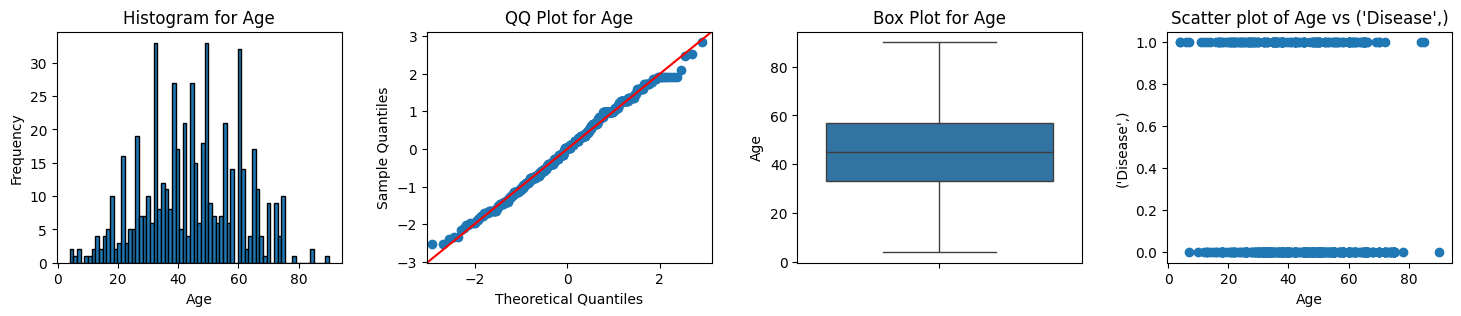

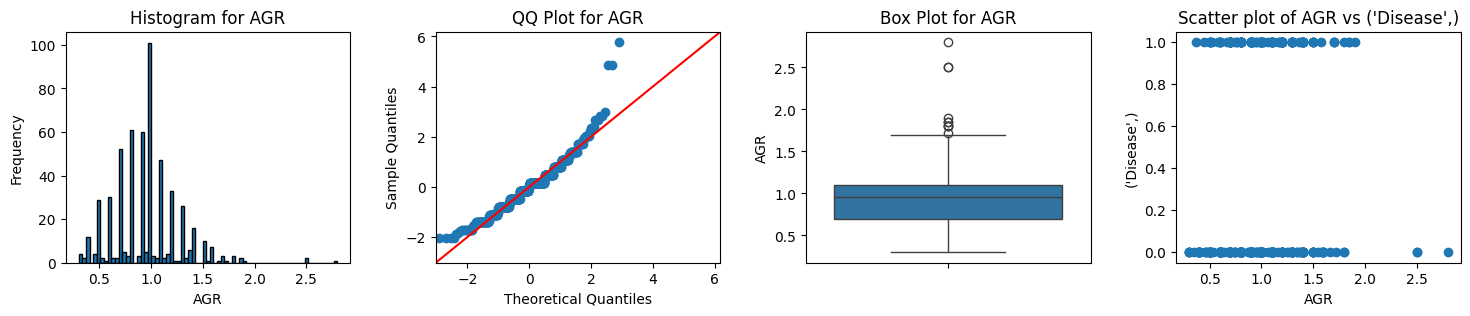

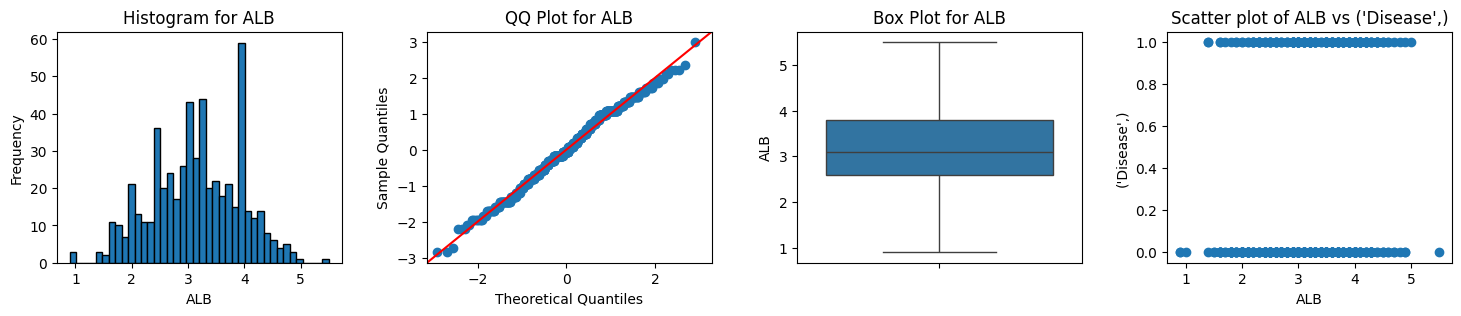

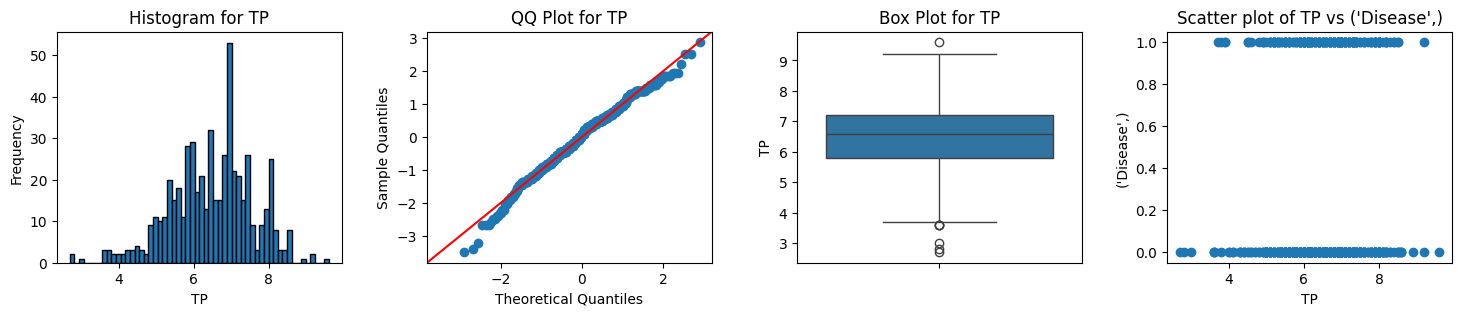

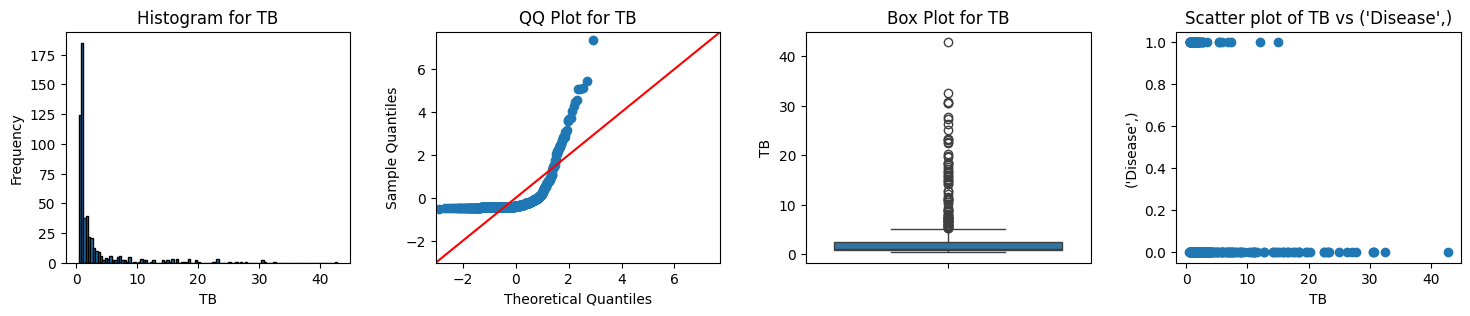

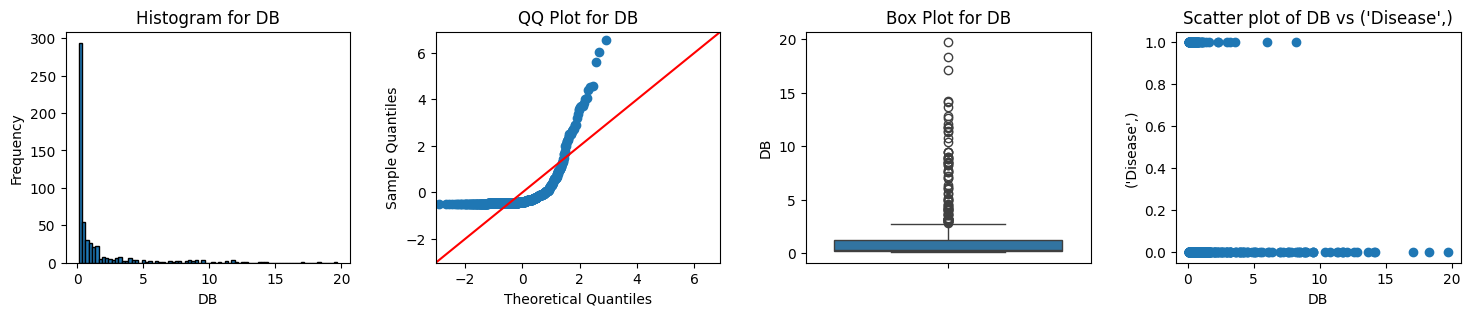

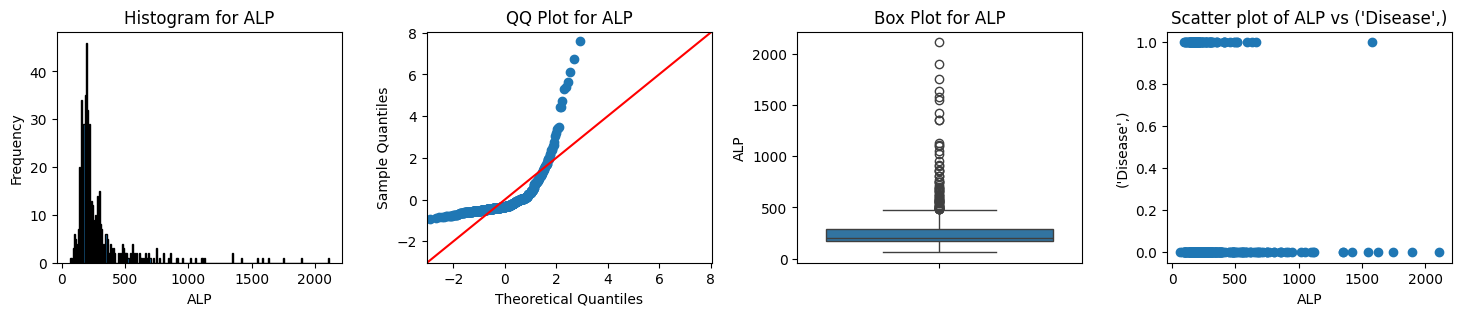

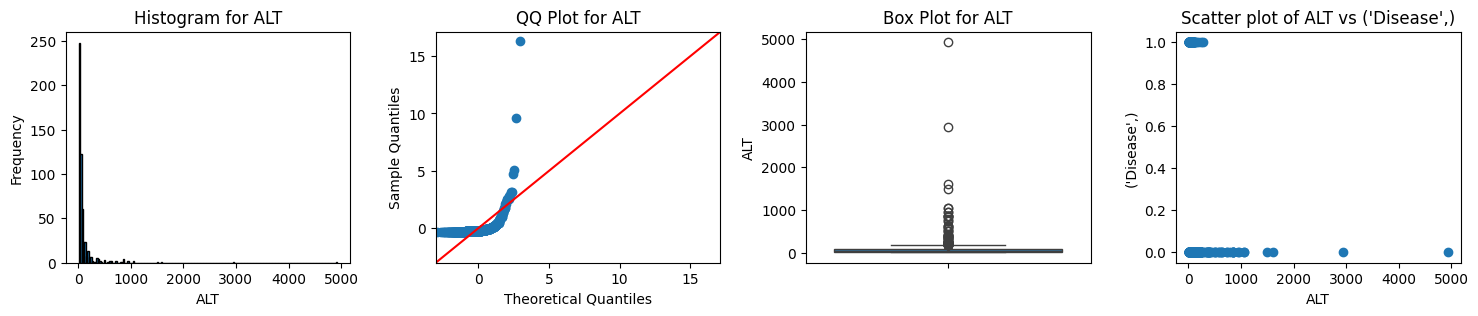

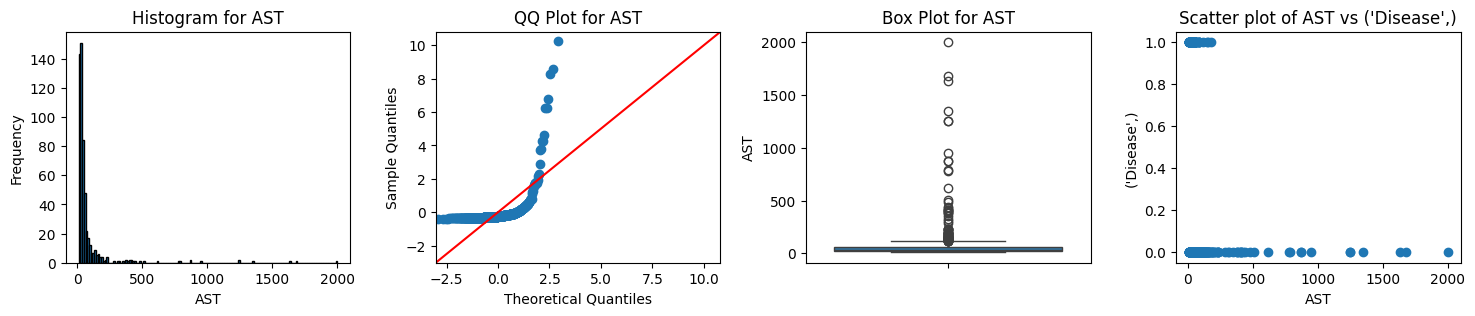

Plotting correlation matrix


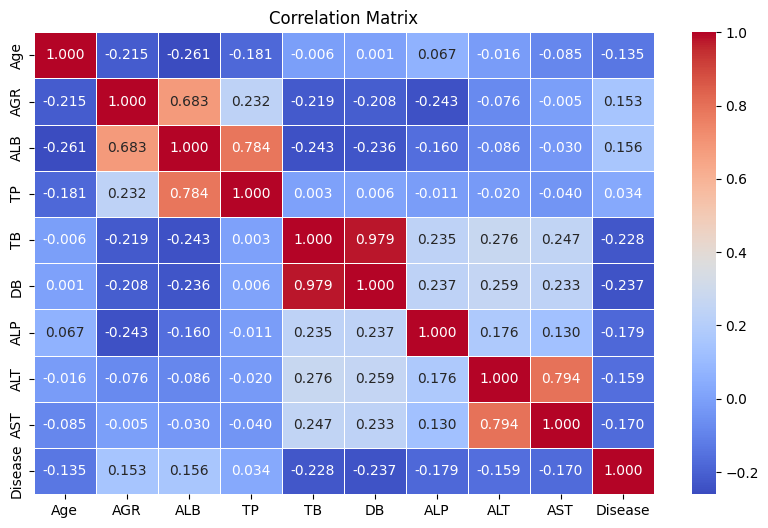

In [8]:
# Check for normal distribution
normal_distribution_list, abnormal_distribution_list = mphd.continous_data.descriptive_analysis(df = mice_df.loc[:,independent_continous + (dependent_variable,)],
                                                                                                independent_variables=independent_continous,
                                                                                                dependent_variables = dependent_variable,
                                                                                                descriptive_type = "continous",
                                                                                                plot_dependent_variables = False,
                                                                                                plot_correlation = True,
                                                                                                round = 4)

In [9]:
# Show outliers with 1.5 * iqr
outliers_df = mphd.continous_data.identify_outliers(df = df, column_name = ["TB", "ALP", "AST", "ALT"], ratio = 1.5)

Outliers found in column of TB with boundaries of -1.55 - 3.55:
+-----+------------+-----+------+------+------+------+------+-----+-----+------+---------+--------+--------+-----+
|     | Patient_ID | Age |  TB  |  DB  | ALP  | ALT  | AST  | TP  | ALB | AGR  | Disease | Ethnic | Gender | bmi |
+-----+------------+-----+------+------+------+------+------+-----+-----+------+---------+--------+--------+-----+
| 366 |    367     | 26  | 42.8 | 19.7 | 390  | 138  |  75  | 7.5 | 2.6 | 0.5  |    0    |   2    |   1    |  0  |
| 327 |    328     | 32  | 32.6 | 14.1 | 219  | 235  |  95  | 5.8 | 3.1 | 1.1  |    0    |   2    |   1    |  0  |
| 346 |    347     | 40  | 30.8 | 18.3 | 285  | 186  | 110  | 7.9 | 2.7 | 0.5  |    0    |   2    |   1    |  0  |
| 173 |    174     | 42  | 30.5 | 14.2 | 285  | 130  |  65  | 5.2 | 2.1 | 0.6  |    0    |   0    |   1    |  1  |
| 326 |    327     | 32  | 30.5 | 17.1 | 218  |  79  |  39  | 5.5 | 2.7 | 0.9  |    0    |   2    |   1    |  0  |
| 355 |    356  

## Descriptive Analysis For Categorical Data

Descriptive Analysis for independent variables:
+--------+--------------------+------------------+-------+------------+
| Gender | Have Liver Disease | No liver disease |  All  | percentage |
+--------+--------------------+------------------+-------+------------+
| Female |        50.0        |       87.0       | 137.0 |   24.77    |
|  Male  |       120.0        |      296.0       | 416.0 |   75.23    |
|  All   |       170.0        |      383.0       | 553.0 |   100.0    |
+--------+--------------------+------------------+-------+------------+


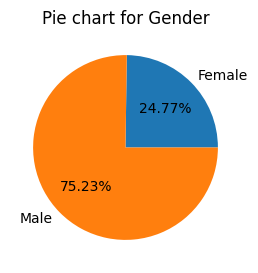

Chi2 test between Gender and Disease have chi2 statistics value = 2.49 and p_value of 0.11
----------------------------------------------------------------
+---------+--------------------+------------------+-------+------------+
| Ethnic  | Have Liver Disease | No liver disease |  All  | percentage |
+---------+--------------------+------------------+-------+------------+
| Chinese |        29.0        |      110.0       | 139.0 |   25.14    |
| Indian  |        46.0        |       93.0       | 139.0 |   25.14    |
|  Malay  |        95.0        |      180.0       | 275.0 |   49.73    |
|   All   |       170.0        |      383.0       | 553.0 |   100.0    |
+---------+--------------------+------------------+-------+------------+


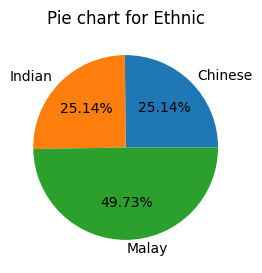

Chi2 test between Ethnic and Disease have chi2 statistics value = 8.60 and p_value of 0.01
----------------------------------------------------------------
+------------+--------------------+------------------+-------+------------+
|    bmi     | Have Liver Disease | No liver disease |  All  | percentage |
+------------+--------------------+------------------+-------+------------+
| Normal BMI |        42.0        |      313.0       | 355.0 |    64.2    |
| Overweight |       128.0        |       70.0       | 198.0 |    35.8    |
|    All     |       170.0        |      383.0       | 553.0 |   100.0    |
+------------+--------------------+------------------+-------+------------+


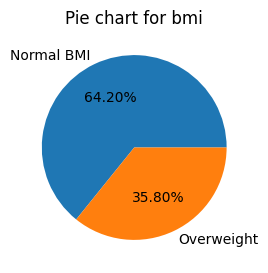

Chi2 test between bmi and Disease have chi2 statistics value = 164.06 and p_value of 0.00
----------------------------------------------------------------
Descriptive Analysis for dependent variables:
+--------------------+-------+
|      Disease       | count |
+--------------------+-------+
| Have Liver Disease |  170  |
|  No liver disease  |  383  |
|        All         |  553  |
+--------------------+-------+


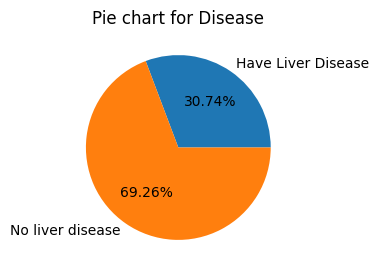

The summary of the statistical tests for independent variable:
+---+----------------------+-----------+------------------+----------+
|   | independent_variable | test_name | statistic_values | p_values |
+---+----------------------+-----------+------------------+----------+
| 0 |        Gender        | Chi2 Test |       2.49       |   0.11   |
| 1 |        Ethnic        | Chi2 Test |       8.6        |   0.01   |
| 2 |         bmi          | Chi2 Test |      164.06      |   0.0    |
+---+----------------------+-----------+------------------+----------+
The chi2 test is positive and indicate there is an association between Disease and Ethnic, bmi.
The chi2 test is negative and indicate there is no association between Disease and Gender
-----------------------------------------------------------
For dependent variable:
+--------------------+-------+------------+
|      Disease       | count | percentage |
+--------------------+-------+------------+
| Have Liver Disease | 170.0 |   30.74

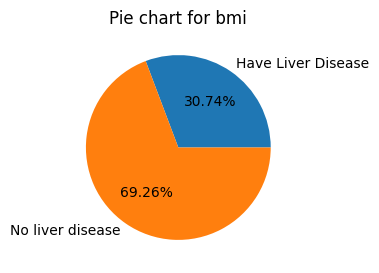

In [10]:
categorical_summary = mphd.categorical_data.categorical_descriptive_analysis(data,
                                                                             independent_variables = independent_categorical,
                                                                             dependent_variables = dependent_variable,
                                                                             analyse_dependent = True)

## To Build Model

In [11]:
# Define train test split
X_train, X_test, y_train, y_test = mphd.pre_processing.train_test_split(df = mice_df,
                                                                        independent_variables=independent_variables,
                                                                        dependent_variable = dependent_variable,
                                                                        test_size = 0.2)

In [ ]:
# Logistic Regression
# set acceptable p value
# acceptable_p_value = 0.05

# # For binominal logistic regression with 2 different depression score outcome along with all independent variable are categorized
# logistic_models, summary_logistic_models = mphd.regression.regression_list(df = mice_df, mode = "sm.Logit",
#                                                                            independent_variables = independent_variables,
#                                                                            dependent_variables = dependent_variable,
#                                                                            p_value_cut_off = acceptable_p_value)


In [ ]:
# To display some information
# columns_to_display = ("variables", "num_variables", "pseudo_r_2", "log_likelihood", "llr_p_value",
#                       "aic_akaike_information_criterion", "bic_bayesin_information_criterion", "coeff_all_significant",
#                       "roc", "shapiro_residual",
#                       "Lagrange_Multiplier", "Lagrange_Multiplier_p-value",
#                       "F-statistic", "F-statistic_p-value")
# summary_logistic_short = mphd.regression.analyse_model_summary(summary_logistic_models.loc[summary_logistic_models.loc[:,"coeff_all_significant"] == True, columns_to_display],
#                                                       top_count = 5,
#                                                       parameters= {"aic_akaike_information_criterion": True,
#                                                                    "bic_bayesin_information_criterion": True,
#                                                                    "pseudo_r_2": False,
#                                                                    "roc":False})
# print(summary_logistic_short.round(4).to_markdown(tablefmt = "pretty"))

In [ ]:
# mphd.regression.selecting_best_model(model_summary = summary_logistic_models.round(4),
#                                      best_index = 699,
#                                      mode = "logistic",
#                                      dependent_variable = "liver disease")

In [ ]:
# To run analysis for crude analysis
# crude_params_df, crude_exp_params_df = mphd.regression.crude_analysis(summary_model_df = summary_logistic_models,
#                                                                         df = df, mode = "logistic_regression",
#                                                                         dependent_variable= dependent_variable,
#                                                                         data_dictionary = data_dictionary,
#                                                                         round_value= 4)

## For Random Forest

In [12]:
settings = {
    "time_budget": 240,  # total running time in seconds
    "metric": 'roc_auc',  # primary metrics for regression can be chosen from: ['mae','mse','r2','rmse','mape']
    "estimator_list": ['rf'],  # list of ML learners; we tune random forest in this example
    "task": 'classification',  # task type
    "log_file_name": None,  # flaml log file
    "seed": None,    # random seed
}

random_forest_model = mphd.machine_learning.automl(X_train, y_train, **settings)
random_forest_model

[flaml.automl.logger: 05-28 22:05:22] {1680} INFO - task = classification
[flaml.automl.logger: 05-28 22:05:22] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 05-28 22:05:22] {1789} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 05-28 22:05:22] {1901} INFO - List of ML learners in AutoML Run: ['rf']
[flaml.automl.logger: 05-28 22:05:22] {2219} INFO - iteration 0, current learner rf


/Users/wh0102/Downloads/github/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[flaml.automl.logger: 05-28 22:05:22] {2345} INFO - Estimated sufficient time budget=2745s. Estimated necessary time budget=3s.
[flaml.automl.logger: 05-28 22:05:22] {2392} INFO -  at 0.3s,	estimator rf's best error=0.2037,	best estimator rf's best error=0.2037
[flaml.automl.logger: 05-28 22:05:22] {2219} INFO - iteration 1, current learner rf
[flaml.automl.logger: 05-28 22:05:22] {2392} INFO -  at 0.6s,	estimator rf's best error=0.2037,	best estimator rf's best error=0.2037
[flaml.automl.logger: 05-28 22:05:22] {2219} INFO - iteration 2, current learner rf
[flaml.automl.logger: 05-28 22:05:22] {2392} INFO -  at 0.8s,	estimator rf's best error=0.2037,	best estimator rf's best error=0.2037
[flaml.automl.logger: 05-28 22:05:22] {2219} INFO - iteration 3, current learner rf
[flaml.automl.logger: 05-28 22:05:23] {2392} INFO -  at 1.1s,	estimator rf's best error=0.1797,	best estimator rf's best error=0.1797
[flaml.automl.logger: 05-28 22:05:23] {2219} INFO - iteration 4, current learner rf


AutoML(append_log=False, auto_augment=True, custom_hp={},
       cv_score_agg_func=None, early_stop=False, ensemble=False,
       estimator_list='auto', eval_method='auto', fit_kwargs_by_estimator={},
       force_cancel=False, free_mem_ratio=0, hpo_method='auto',
       keep_search_state=False, learner_selector='sample', log_file_name='',
       log_training_metric=False, log_type='better', max_iter=None,
       mem_thres=4294967296, metric='auto', metric_constraints=[],
       min_sample_size=10000, mlflow_logging=True, model_history=False,
       n_concurrent_trials=1, n_jobs=-1, n_splits=5, pred_time_limit=inf,
       preserve_checkpoint=True, retrain_full=True, ...)

In [13]:
rf_params = {'classifier__max_depth':[7],
              'smote__sampling_strategy': [0.8],
              'classifier__min_samples_split':[10],
              'classifier__max_features':[0.8],
              'classifier__criterion':["entropy"],
              'classifier__bootstrap':[True],
              'classifier__n_estimators':[200],
              'classifier__min_samples_leaf':[8]}

random_forest_grid_search, time_required = mphd.machine_learning.random_forest(X_train = X_train, y_train = y_train,
                                                                               params = rf_params, random_seed = 11)

Time taken: 3.855 seconds


In [14]:
rf_summary_df = mphd.analyse_ml.analyse_ml(random_forest_grid_search, model_type="Random Forest",
                                           independent_variables=independent_variables, X_test=X_test, y_test=y_test)

Best Params:
{'classifier__bootstrap': True,
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 7,
 'classifier__max_features': 0.8,
 'classifier__min_samples_leaf': 8,
 'classifier__min_samples_split': 10,
 'classifier__n_estimators': 200,
 'smote__sampling_strategy': 0.8}
------------------------------------------------


NameError: name 'np' is not defined

<Figure size 1200x600 with 0 Axes>

LightGBM

In [ ]:
X_train, X_test, y_train, y_test = mphd.pre_processing.train_test_split(df = mice_df,
                                                                        independent_variables=independent_variables,
                                                                        dependent_variable = dependent_variable,
                                                                        test_size = 0.1)

lgbm_params = {'classifier__max_depth': [3,4,5],
               'classifier__learning_rate' : [0.1, 0.2], 
               'classifier__min_child_weight' : range(1,3,1), 
               'classifier__boosting_type' : ['gbdt'], 
               'smote__sampling_strategy': np.linspace(0.5, 0.9, 2),
               'classifier__reg_alpha':[1e-5,0.01,0.03], 
               'classifier__num_leaves':[6]}

grid_search, time_required = mphd.machine_learning.LightGBM(X_train = mice_df.loc[:,independent_variables], y_train = mice_df.loc[:,dependent_variable], 
                                                            params = lgbm_params,
                                                            independent_variables_continous = independent_continous)

[LightGBM] [Info] Number of positive: 276, number of negative: 307
[LightGBM] [Info] Number of positive: 275, number of negative: 306
[LightGBM] [Info] Number of positive: 276, number of negative: 307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 746
[LightGBM] [Info] Number of positive: 275, number of negative: 306
[LightGBM] [Info] Number of positive: 275, number of negative: 306
[LightGBM] [Info] Number of data points in the train set: 583, number of used features: 12
[LightGBM] [Info] Number of positive: 275, number of negative: 306
[LightGBM] [Info] Number of positive: 276, number of negative: 307
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473413 -> initscore=-0.106447
[LightGBM] [Info] Start training from score -0.106447
[LightGBM] [Info] Number of positive: 275, number of negative: 306
[LightGBM] [Info] Auto-choosing col-wise mul

/Users/wh0102/Downloads/github/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/wh0102/Downloads/github/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/wh0102/Downloads/github/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/wh0102/Downloads/github/.venv/li